In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xlrd as xlrd

In [2]:
#Macklan's CODE
fema = gpd.read_file("Data\\FEMA_6\\FEMA_6.shp")
fema = fema.sort_values(by='CTFIPS')

In [3]:
#Macklan's CODE
def ag_count(state):
    data = gpd.read_file("Data/SoVI2010_" + state + "/SoVI0610_" + state + ".shp")
    
    ## Creating CTFIPS, which FEMA data uses for counties
    data['CTFIPS'] = data['STATEFP10'] + data['COUNTYFP10']
    
    ## Aggregating SOVI data from block to county level
    data = data.groupby('CTFIPS').agg({"SOVI0610" + state: "mean", "P0010001": "sum"})
   
    ## Combining fema and sovi data for each county
    data = fema.merge(data, on="CTFIPS", how="right")
    
    ## Renaming the columns to things that make sense
    data = data.rename(columns={
        "SOVI0610" + state: "SOVI",
        "P0010001": "POPULATION",
        "TOTAL_DECL": "TOTAL_DECLARATIONS"
    })
    
    data = data.sort_values(by='CTFIPS')
    
    ## Creating a scale of the SOVI and FEMA data from 1 - number of counties in a state
    data['SOVI_SCORE'] = data['SOVI'].rank()
    data['FEMA_SCORE'] = data['TOTAL_DECLARATIONS'].rank()
    sovi = []
    fema_ranks = []
    rank = []
    n = len(data)
    
    ## Taking the SOV_SCORE and FEMA_SCORE, assign a SOVI_RANK and FEMA_RANK
    ## Rank = the correlation of SOV_SCORE and FEMA_SCORE, matching highs and lows and finding where it is different
    for index, row in data.iterrows():
        if row.SOVI_SCORE < (n/3):
            ## Low - Low = 1
            if row.FEMA_SCORE < (n/3):
                rank.append(1)
                fema_ranks.append(1)
            ## Low - High = 2
            elif row.FEMA_SCORE > (2 * (n/3)):
                rank.append(2)
                fema_ranks.append(3)
            ## Medium, don't care for rank
            else:
                rank.append(-1)
                fema_ranks.append(2)
            sovi.append(1)
        elif row.SOVI_SCORE > (2 * (n/3)):
            ## High - High = 4
            if row.FEMA_SCORE > (2 * (n/3)):
                rank.append(4)
                fema_ranks.append(3)
            ## High - Low = 3
            elif row.FEMA_SCORE < (n/3):
                rank.append(3)
                fema_ranks.append(1)
            ## Medium, don't care for rank
            else:
                rank.append(-1)
                fema_ranks.append(2)
            sovi.append(3)
        else:
            rank.append(-1)
            sovi.append(2)
            if row.FEMA_SCORE > (2 * (n/3)):
                fema_ranks.append(3)
            elif row.FEMA_SCORE < (n/3):
                fema_ranks.append(1)
            else:
                fema_ranks.append(2)
    ## Attaching the ranks to dataframe
    data['RANK'] = rank
    data['SOVI_RANK'] = sovi
    data['FEMA_RANK'] = fema_ranks
    return data

CA = ag_count("CA")
FL = ag_count("FL")
IN = ag_count("IN")
LA = ag_count("LA")
ME = ag_count("ME")
WA = ag_count("WA")

In [4]:
##Macklan's CODE
## Combining all of the states into one dataframe
## The rank columns don't show because there is 52 columns, so they are hidden
sovi = CA.append([FL, IN, LA, ME, WA])
sovi = sovi.sort_values(by='CTFIPS')
#sovi.head()

C:\Users\seanf\Anaconda2\envs\LULW\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
## Beginning of Sean's CODE, previous is Macklan's
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xlrd as xlrd

##Making sure CTFIPS in both tables are same type
sovi['CTFIPS'] = sovi['CTFIPS'].astype(int)

##Reading in poverty data
poverty = pd.read_excel("Data\\PovertyRate6States_Counties.xlsx")
poverty = poverty.sort_values(by='CTFIPS')

##Making sure CTFIPS in both tables are same type
poverty['CTFIPS'] = poverty['CTFIPS'].astype(int)
#poverty.head()


In [6]:
##Merging Poverty table to SoVI table
poverty = sovi.merge(poverty, on='CTFIPS', how='right')
#poverty['CTFIPS']

#print(poverty.columns.values) #making sure it worked

poverty = poverty.rename(columns={'RANK_x': 'RANK'}) #Renaming because colums duplicated when merged
#print(poverty['RANK'])


In [15]:
##The code that is #'d ahead is my attempt at linear regression between two variables, was unable to figure it out
##Does not have to be included in final product


#X = poverty['RANK']
#print(X)
#Y = poverty['PERCENT']
#print(Y)
#sns.distplot(poverty['RANK'])
#df_x = pd.DataFrame(poverty.RANK)
#df_x.describe()
#df_y = pd.DataFrame(poverty.PERCENT)
#df_y.describe()
#from sklearn import linear_model
#from sklearn.model_selection import train_test_split
#array1 = poverty[['RANK', 'PERCENT']]
#print(array1)
#array1.corr()
#poverty.describe()
#reg = linear_model.LinearRegression()
#x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=4)
#reg.fit(x_train,y_train)
#reg.coef_
#a=reg.predict(x_test)
#a[14]
#y_test

Text(0.5,0,'Poverty Rate')

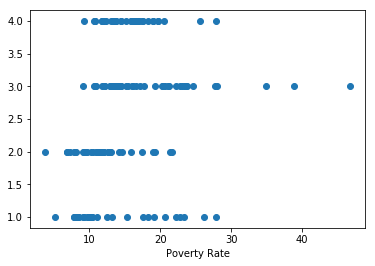

In [22]:
##Beginning of Correlation Code between multiple variables/relationships

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#poverty.columns
#poverty.shape
#poverty.info()

poverty_0 = poverty.drop(poverty[poverty.RANK < 0].index) #Removed ranks less than 0 because they are all "Medium"
plt.scatter(poverty_0.PERCENT,poverty_0.RANK) #Scatter Plot to see correlation more clearly
poverty_0['RANK'].corr(poverty_0['PERCENT']) #Correlation between Rank and Poverty Rate
#plt.ylabel('Combined SoVI/Disasters Rank')
plt.xlabel('Poverty Rate')

Text(0.5,0,'Declared Disasters')

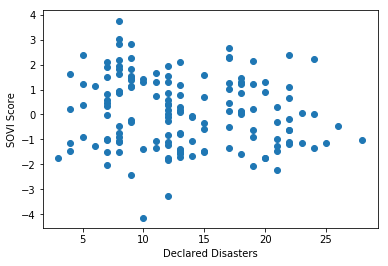

In [18]:
#Correlation and Scatter for Declared Disasters and SoVI Score
poverty_0['TOTAL_DECLARATIONS'].corr(poverty_0['SOVI_SCORE'])
plt.scatter(poverty_0.TOTAL_DECLARATIONS,poverty_0.SOVI)
plt.ylabel('SOVI Score')
plt.xlabel('Declared Disasters')

Text(0.5,0,'Declared Disasters')

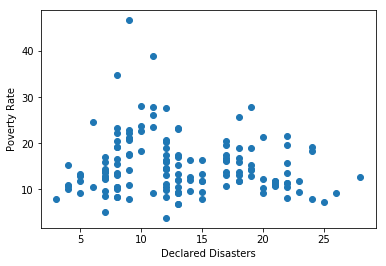

In [19]:
##Correlation and Scatter for Declared Disasters and Poverty Rate
poverty_0['TOTAL_DECLARATIONS'].corr(poverty_0['PERCENT'])
plt.scatter(poverty_0.TOTAL_DECLARATIONS,poverty_0.PERCENT)
plt.ylabel('Poverty Rate')
plt.xlabel('Declared Disasters')

- Weak uphill linear relationship between SoVI/Declared Disasters and Poverty Percentage.
- Weak downhill linear relationship between Total number of declarations per county and SoVI Score.
- Very weak relationship between the number of declared disasters in a county and the poverty rate of that county.

From these findings we can conclude that there is a very weak linear relationship between the combined SoVI/Declared Disasters Rank and Poverty Rate (0.2382112946516158), as well as FEMA Declarations and SoVI Score(-0.2618102351422398).

In the graph showing the SoVI Ranks and Poverty Rates, the clusters between ranks 1-4 move right slightly to higher poverty rates, but not enough to indicate there is a strong relationship.

We also calculated the number of disaster declarations per county and compared them to the poverty rate, but found an even weaker relationship between these two variables (-0.10765106401114274).